# Exponential models

This notebook is to play around with exponential models.

## Install libraries to cloud worker

In [1]:
! conda install statsmodels -y
! conda install scikit-learn -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## Import modules

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

## Read data to memory

In [3]:
df = pd.read_csv("../outputs/mutational_model_stats.tsv", sep="\t")
df.head(4)

,tri,ref,alt,lvl,mu,sqrt_mu,obs,pos
0,AAA,A,C,0,1.800000e-09,0.000042,0.046519,27021
1,AAA,A,G,0,3.010000e-09,0.000055,0.098643,204496
2,AAA,A,T,0,1.040000e-09,0.000032,0.026177,42557
3,AAC,A,C,0,1.420000e-09,0.000038,0.032891,14989


## Plot "mu" vs "obs"

In [4]:
sns.set_context("talk")

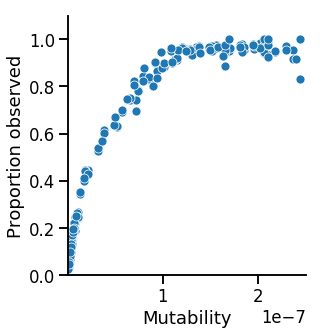

In [5]:
g = (sns.relplot(kind="scatter",
                 data=df,
                 x="mu",
                 y="obs",
                )
    )
(g.set(xlim=(8.9*10**-10, 2.5*10**-7),
       ylim=(0,1.1),
       xlabel="Mutability",
       ylabel="Proportion observed"
      )
)

This looks like a nice exponential relationship which caps at 1. (The proportion of observed variants can't be >1).

I want to fit a curve which describes this relationship. Later, I want to use this model to predict "obs" (the proportion observed) for other values of "mu" (mutability).

### Contexts where all possible variants are observed

In [6]:
print(f"Contexts = {len(df)}")
print(f'There are {(df["obs"]==1).sum()} observations for which "obs" == 1. Drop them.')
df = df[df["obs"] != 1].copy()
print(f"Contexts remaining = {len(df)}")

Contexts = 304
There are 5 observations for which "obs" == 1. Drop them.
Contexts remaining = 299


## Fit the model

The approach below matches that in from the gnomAD code base at https://github.com/atgu/gnomad_nc_constraint

In [7]:
def sem(p, n): return np.sqrt((p*(1-p))/n)

In [8]:
# Fit a polynomial equation
## Weight by 1 / sem("obs"), as per gnomAD paper
fit = np.polyfit(df["mu"], np.log(1 - df["obs"]), 1, w=(1/sem(df["obs"], df["pos"])))
#fit = np.polyfit(df["mu"], np.log(1 - df["obs"]), 1, w=(df["pos"]))

# Create a polynomial evaluator
p = np.poly1d(fit)

A,B = fit # Get the coefficients
print(f"A = {A}")
print(f"B = {B}")

# The expressions below are equivalent
df["fit_obs"] = 1 - (np.exp(B)) * (np.exp(A * df["mu"]))
#df["fit_obs"] = 1 - np.exp(p(df["mu"]))

# R**2 for "obs" and "fit_obs"
print(f'R2 for "obs" vs "fit_obs" = {r2_score(df["obs"], df["fit_obs"])}')

A = -23025162.179456074
B = -0.023470852796130738
R2 for "obs" vs "fit_obs" = 0.9938988211074241


### Plots 

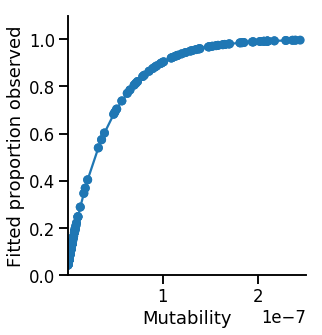

In [9]:
# Plot "mu" vs "fit_obs"
g = (sns.relplot(kind="scatter",
                 data=df,
                 x="mu",
                 y="fit_obs",
                 edgecolor="none",
               )
    )

# Modify figure
(g.set(xlim=(8.9*10**-10, 2.5*10**-7),
       ylim=(0,1.1),
       xlabel="Mutability",
       ylabel="Fitted proportion observed",
      )
)

# Add trend line
plt.plot(sorted(df["mu"]), sorted(df["fit_obs"]))

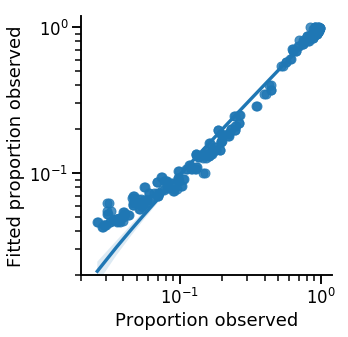

In [10]:
# Plot "obs" vs "fit_obs"
g = sns.lmplot(data=df, x="obs", y="fit_obs")
(g.set(xlabel = "Proportion observed", 
       ylabel="Fitted proportion observed", 
       xscale="log", 
       yscale="log",
       xlim=(0.02, 1.2),
       ylim=(0.02, 1.2),
      )
)